In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re


In [2]:
#retrieve dataset
foodproduct = pd.read_excel("C:/Users/user/Desktop/Data Stuffs/Portfolio Projects/Food_Products/Foodproducts.xlsx", engine='openpyxl')

In [3]:
'''data cleaning: removing all columns with too many nulls'''
na = foodproduct.isna().sum(axis = 0)
print(foodproduct.shape)
na_percent = na/foodproduct.shape[0] * 100
cols_to_discard = []
#making the percentage of nulls database
na_percent_db = na_percent.reset_index()
na_percent_db.columns = ['col_name', 'percent']
na_db_filter = na_percent_db[na_percent_db['percent'] < 20]

foodproduct_nonull = foodproduct.drop(na_db_filter['col_name'], axis=1)
print(foodproduct_nonull.columns)

(356027, 163)
Index(['generic_name', 'quantity', 'packaging', 'packaging_tags', 'categories',
       'categories_tags', 'categories_en', 'origins', 'origins_tags',
       'manufacturing_places',
       ...
       'fruits-vegetables-nuts_100g', 'fruits-vegetables-nuts-estimate_100g',
       'collagen-meat-protein-ratio_100g', 'cocoa_100g', 'chlorophyl_100g',
       'carbon-footprint_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g',
       'water-hardness_100g'],
      dtype='object', length=143)


In [4]:
#looking into imputation (if possible) + doing some amendments to some essential columns
'''
Columns that can be looked into:
1. overall weight/ quantity (to convert them into just numbers)
Current units: g/gr/grams, kg, oz, cl (ml x 1000), ml, oz/ounces, lb/pounds, 
2. packaging tags (because packaging is too CHAOTIC)
3. categories tags (take the english version one)
4. amend the serving size column to just take standard units
5. any state or category columns without tags can be removed
6. don't remove nutrition level for each nutrient component
'''

multiply1k = ['kg', 'L', 'liters', 'litres', 'litre', 'liter']
multiplyhundo = ['cl']
multiply350 = ['oz', 'ounce', 'ounces']
multiply450 = ['lb', 'pound', 'pounds']
retain = ['g', 'gr', 'gram', 'grammes', 'grams']

#doing quantity amendments
print(foodproduct_nonull['quantity'].unique().tolist())
foodproduct_quan = foodproduct[foodproduct['quantity'].isna() == False]
'''foodproduct_nonull[['quantity_num1', 'quantity_num2']] = foodproduct_nonull['quantity_num'].str.split(' ', n=1, expand=True)
foodproduct_nonull[['quantity_num1','quantity_num2']]
#foodproduct_nonull['quantity_num'] = [(foodproduct_nonull['quantity_num'] * 1000) if foodproduct_nonull['quantity'].str.contains('kg|L|liters|litres|litre|liter') else foodproduct_nonull['quantity_num']]

foodproduct_nonull_quan = foodproduct_nonull[['generic_name', 'quantity', 'quantity_num', 'quantity_num1', 'quantity_num2']]
'''

['1kg', nan, '250ml', '2.46 kg', '230g', '60 capsules', '500g', '2l', '0.980 kg', '1.150 kg', '170g', '45g', '1.200 kg', '1.008 kg / 12 pain', '1 kg ', '33 cl e', '1 kg', '1 400 kg', '1250 kg', '46,7 g', '75 g', '4 x 5 cl', '1 bun', '500 g', '686 g', '75 cl e', '250 g', '454g', '907g', '19 g', '46.2gr', '15 cl', '5 ml', '34g', '500ml', '33cl', '1', '400g', '300 g (neto)', '33 cl', '175g', '880 g', '6', '2,5 kg', '25 g', '900 g', '600 g', '792 g', '2 kg', '2000g', '660 g (30 pâtisseries)', '1000g', '660 g (30 étuis individuels)', '3.5 oz', '3 oz', '80g', '1 l.', '980g', '100 g', '200 g', '130 g', '180 g', '90 g', '80 g', '65 g', '50 g', '230 g e', '225 g e', '225 g', '225 g (10 cookies)', '320 g', '750', '160 g', '10 L e (1 * 10 L e)', '7.788 kg (6 * 1,298 kg)', '400 g', '454 g', '32 FL OZ (1 QT) 946 mL', '350 g', '15 oz, 425g', '10 kg (5 * 2 kg)', '330 g e', '250g', '740 g (20 étuis individuels)', '275 g', '257 g', '500 ml', '1 LB (517 g)', '120 g', '150 g', '125 g', '45 g e', '132 g',

"foodproduct_nonull[['quantity_num1', 'quantity_num2']] = foodproduct_nonull['quantity_num'].str.split(' ', n=1, expand=True)\nfoodproduct_nonull[['quantity_num1','quantity_num2']]\n#foodproduct_nonull['quantity_num'] = [(foodproduct_nonull['quantity_num'] * 1000) if foodproduct_nonull['quantity'].str.contains('kg|L|liters|litres|litre|liter') else foodproduct_nonull['quantity_num']]\n\nfoodproduct_nonull_quan = foodproduct_nonull[['generic_name', 'quantity', 'quantity_num', 'quantity_num1', 'quantity_num2']]\n"

In [5]:
#Merge the nonull cell with the new quan cell.
foodproduct_quann = pd.read_excel("C:/Users/user/Desktop/Data Stuffs/Portfolio Projects/Food_Products/foodproductsquan 1.xlsx")
foodproduct_new = pd.merge(foodproduct_quan, foodproduct_quann, how = 'inner', on = foodproduct_quan.index)
foodproduct_new_nonull = foodproduct_new[foodproduct_new['generic_name'].isna() == True]
foodproduct_new_nonull['quantity clean'] = foodproduct_new_nonull['quantity clean'].str.replace(',', '.')
foodproduct_new_nonull['quantity clean'] = foodproduct_new_nonull['quantity clean'].str.replace(' ', '')
foodproduct_new_nonull['numeric_weight'] = foodproduct_new_nonull['quantity clean'].str.extract(r'(\d+.\d+)')
foodproduct_new_nonull['weight_unit'] = foodproduct_new_nonull['quantity clean'].replace("\d+", "", regex = True)
foodproduct_new_nonull['weight_unit_clean'] = foodproduct_new_nonull['weight_unit'].str.replace('.', '')
foodproduct_new_nonull['weight_unit_clean'] = foodproduct_new_nonull['weight_unit_clean'].str.replace(',', '')
foodproduct_new_nonull['weight_unit_clean'] = foodproduct_new_nonull['weight_unit_clean'].str.replace('/', '')
foodproduct_new_nonull['weight_unit_clean'] = foodproduct_new_nonull['weight_unit_clean'].str.replace('gs', 'g')
foodproduct_new_nonull['weight_unit_clean'] = foodproduct_new_nonull['weight_unit_clean'].str.replace(' ', '')
foodproduct_new_nonull['weight_unit_clean'] = foodproduct_new_nonull['weight_unit_clean'].str.replace('lB', 'lb')
foodproduct_new_nonull.loc[:,['numeric_weight', 'weight_unit_clean']]
print(foodproduct_new_nonull['weight_unit_clean'].unique())

<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
C:\Users\user\AppData\Local\Temp\ipykernel_16032\3135584562.py:8: SyntaxWarning: invalid escape sequence '\d'
  foodproduct_new_nonull['weight_unit'] = foodproduct_new_nonull['quantity clean'].replace("\d+", "", regex = True)
C:\Users\user\AppData\Local\Temp\ipykernel_16032\3135584562.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foodproduct_new_nonull['quantity clean'] = foodproduct_new_nonull['quantity clean'].str.replace(',', '.')
C:\Users\user\AppData\Local\Temp\ipykernel_16032\3135584562.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

['kg' 'ml' 'g' 'notuseful' 'l' 'cl' 'oz' 'lb' 'gal' 'gallon' 'mg' nan ''
 'kl' 'pounds' 'pound' 'k' 'xcl' '-g' 'gi' 'Milani' 'xg' 'oog' 'xl' 'Ol'
 'Slline' '℮l' 'lr' 'dl' "'l" '€' 'f' 'can']


C:\Users\user\AppData\Local\Temp\ipykernel_16032\3135584562.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foodproduct_new_nonull['weight_unit_clean'] = foodproduct_new_nonull['weight_unit_clean'].str.replace('/', '')
C:\Users\user\AppData\Local\Temp\ipykernel_16032\3135584562.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foodproduct_new_nonull['weight_unit_clean'] = foodproduct_new_nonull['weight_unit_clean'].str.replace('gs', 'g')
C:\Users\user\AppData\Local\Temp\ipykernel_16032\3135584562.py

In [6]:
#doing the real stuffs now
units_legit = ['kg', 'ml', 'g', 'cl', 'oz', 'gal', 'gallon', 'l', 'lb', 'L', 'mg', 'pound', 'pounds']

foodproduct_new_analyze = foodproduct_new_nonull[foodproduct_new_nonull['weight_unit_clean'].isin(units_legit) == True]
foodproduct_new_analyze = foodproduct_new_analyze[foodproduct_new_analyze['numeric_weight'].isna() == False].reset_index()
print(foodproduct_new_analyze['weight_unit_clean'].unique())
foodproduct_new_analyze.loc[:,['numeric_weight', 'weight_unit_clean']]

['ml' 'kg' 'g' 'oz' 'l' 'gal' 'mg' 'cl' 'lb']


,numeric_weight,weight_unit_clean
0,250,ml
1,2.46,kg
2,230,g
3,500,g
4,170,g
...,...,...
45094,100,g
45095,180,g
45096,100,g
45097,180,g


In [9]:
#doing conversions to the same units
"""
1. gallon = 3.78 L = 3780ml
2. oz = 0.03L = 30ml
3. L, kg = 1000ml, g respectively
4. pound = 450g
5. mg = 0.001g
6. cl = 10ml
['ml' 'kg' 'g' 'oz' 'l' 'gal' 'mg' 'cl' 'lb']
"""

foodproduct_new_analyze = foodproduct_new_analyze[foodproduct_new_analyze['numeric_weight'].isna() == False]
foodproduct_new_analyze['numeric_weight'] = foodproduct_new_analyze['numeric_weight'].str.replace(',','.')
foodproduct_new_analyze['converted_weight'] = foodproduct_new_analyze['numeric_weight'].astype('float')
foodproduct_new_analyze['converted_weight'] = np.where(foodproduct_new_analyze['weight_unit_clean'] == 'gal', foodproduct_new_analyze['converted_weight'] * 3780, foodproduct_new_analyze['converted_weight'])
foodproduct_new_analyze['converted_weight'] = np.where(foodproduct_new_analyze['weight_unit_clean'] == 'l', foodproduct_new_analyze['converted_weight'] * 1000, foodproduct_new_analyze['converted_weight'])
foodproduct_new_analyze['converted_weight'] = np.where(foodproduct_new_analyze['weight_unit_clean'] == 'kg', foodproduct_new_analyze['converted_weight'] * 1000, foodproduct_new_analyze['converted_weight'])
foodproduct_new_analyze['converted_weight'] = np.where(foodproduct_new_analyze['weight_unit_clean'] == 'oz', foodproduct_new_analyze['converted_weight'] * 30, foodproduct_new_analyze['converted_weight'])
foodproduct_new_analyze['converted_weight'] = np.where(foodproduct_new_analyze['weight_unit_clean'] == 'mg', foodproduct_new_analyze['converted_weight'] * 0.001, foodproduct_new_analyze['converted_weight'])
foodproduct_new_analyze['converted_weight'] = np.where(foodproduct_new_analyze['weight_unit_clean'] == 'cl', foodproduct_new_analyze['converted_weight'] * 10, foodproduct_new_analyze['converted_weight'])
foodproduct_new_analyze['converted_weight'] = np.where(foodproduct_new_analyze['weight_unit_clean'] == 'lb', foodproduct_new_analyze['converted_weight'] * 450, foodproduct_new_analyze['converted_weight'])
print(foodproduct_new_analyze.columns)
#foodproduct_new_analyze.loc[:,['numeric_weight', 'weight_unit_clean', 'converted_weight']]

Index(['index', 'key_0', 'code', 'url', 'creator', 'created_t',
       'created_datetime', 'last_modified_t', 'last_modified_datetime',
       'product_name',
       ...
       'glycemic-index_100g', 'water-hardness_100g', 'Unnamed: 0',
       'gneric_name', 'quantity_y', 'quantity clean', 'numeric_weight',
       'weight_unit', 'weight_unit_clean', 'converted_weight'],
      dtype='object', length=173)


In [53]:
#remove unwanted columns
pd.options.display.max_seq_items = 2000
foodproduct_analysis = foodproduct_new_analyze.drop(columns=['key_0', 'code', 'url', 'creator', 'created_t',
       'created_datetime', 'last_modified_t', 'last_modified_datetime', 'quantity_x', 'packaging', 'brands', 'categories', 'origins',
       'manufacturing_places', 'manufacturing_places_tags','labels','labels_tags', 'labels_en','emb_codes', 'emb_codes_tags',
       'first_packaging_code_geo', 'cities','purchase_places', 'stores', 'countries','packaging_tags', 'countries_en', 'ingredients_text',
       'allergens', 'allergens_en', 'traces','traces_tags','traces_en', 'serving_size','no_nutriments','additives_en','weight_unit','gneric_name', 'quantity_y', 'quantity clean',
       'Unnamed: 0','additives_n','additives','additives_tags','ingredients_from_palm_oil_n','ingredients_from_palm_oil','ingredients_from_palm_oil_tags',
       'ingredients_that_may_be_from_palm_oil_n','nutrition_grade_uk', 'nutrition_grade_fr', 'pnns_groups_1', 'pnns_groups_2', 'states',
       'states_tags', 'states_en','main_category', 'image_url', 'image_small_url'])
print(foodproduct_analysis.columns)

foodproduct_corr = foodproduct_analysis.drop(columns=[
    'index', 'product_name', 'generic_name', 'brands_tags',
       'categories_tags', 'categories_en', 'origins_tags', 'cities_tags',
       'countries_tags', 'ingredients_that_may_be_from_palm_oil',
       'ingredients_that_may_be_from_palm_oil_tags', 'main_category_en','weight_unit_clean',
])

Index(['index', 'product_name', 'generic_name', 'brands_tags',
       'categories_tags', 'categories_en', 'origins_tags', 'cities_tags',
       'countries_tags', 'ingredients_that_may_be_from_palm_oil',
       'ingredients_that_may_be_from_palm_oil_tags', 'main_category_en',
       'energy_100g', 'energy-from-fat_100g', 'fat_100g', 'saturated-fat_100g',
       '-butyric-acid_100g', '-caproic-acid_100g', '-caprylic-acid_100g',
       '-capric-acid_100g', '-lauric-acid_100g', '-myristic-acid_100g',
       '-palmitic-acid_100g', '-stearic-acid_100g', '-arachidic-acid_100g',
       '-behenic-acid_100g', '-lignoceric-acid_100g', '-cerotic-acid_100g',
       '-montanic-acid_100g', '-melissic-acid_100g',
       'monounsaturated-fat_100g', 'polyunsaturated-fat_100g',
       'omega-3-fat_100g', '-alpha-linolenic-acid_100g',
       '-eicosapentaenoic-acid_100g', '-docosahexaenoic-acid_100g',
       'omega-6-fat_100g', '-linoleic-acid_100g', '-arachidonic-acid_100g',
       '-gamma-linolenic-acid

'\ncan see if any of the various nutrition levels are linked as well\n'

<Figure size 6000x3000 with 0 Axes>

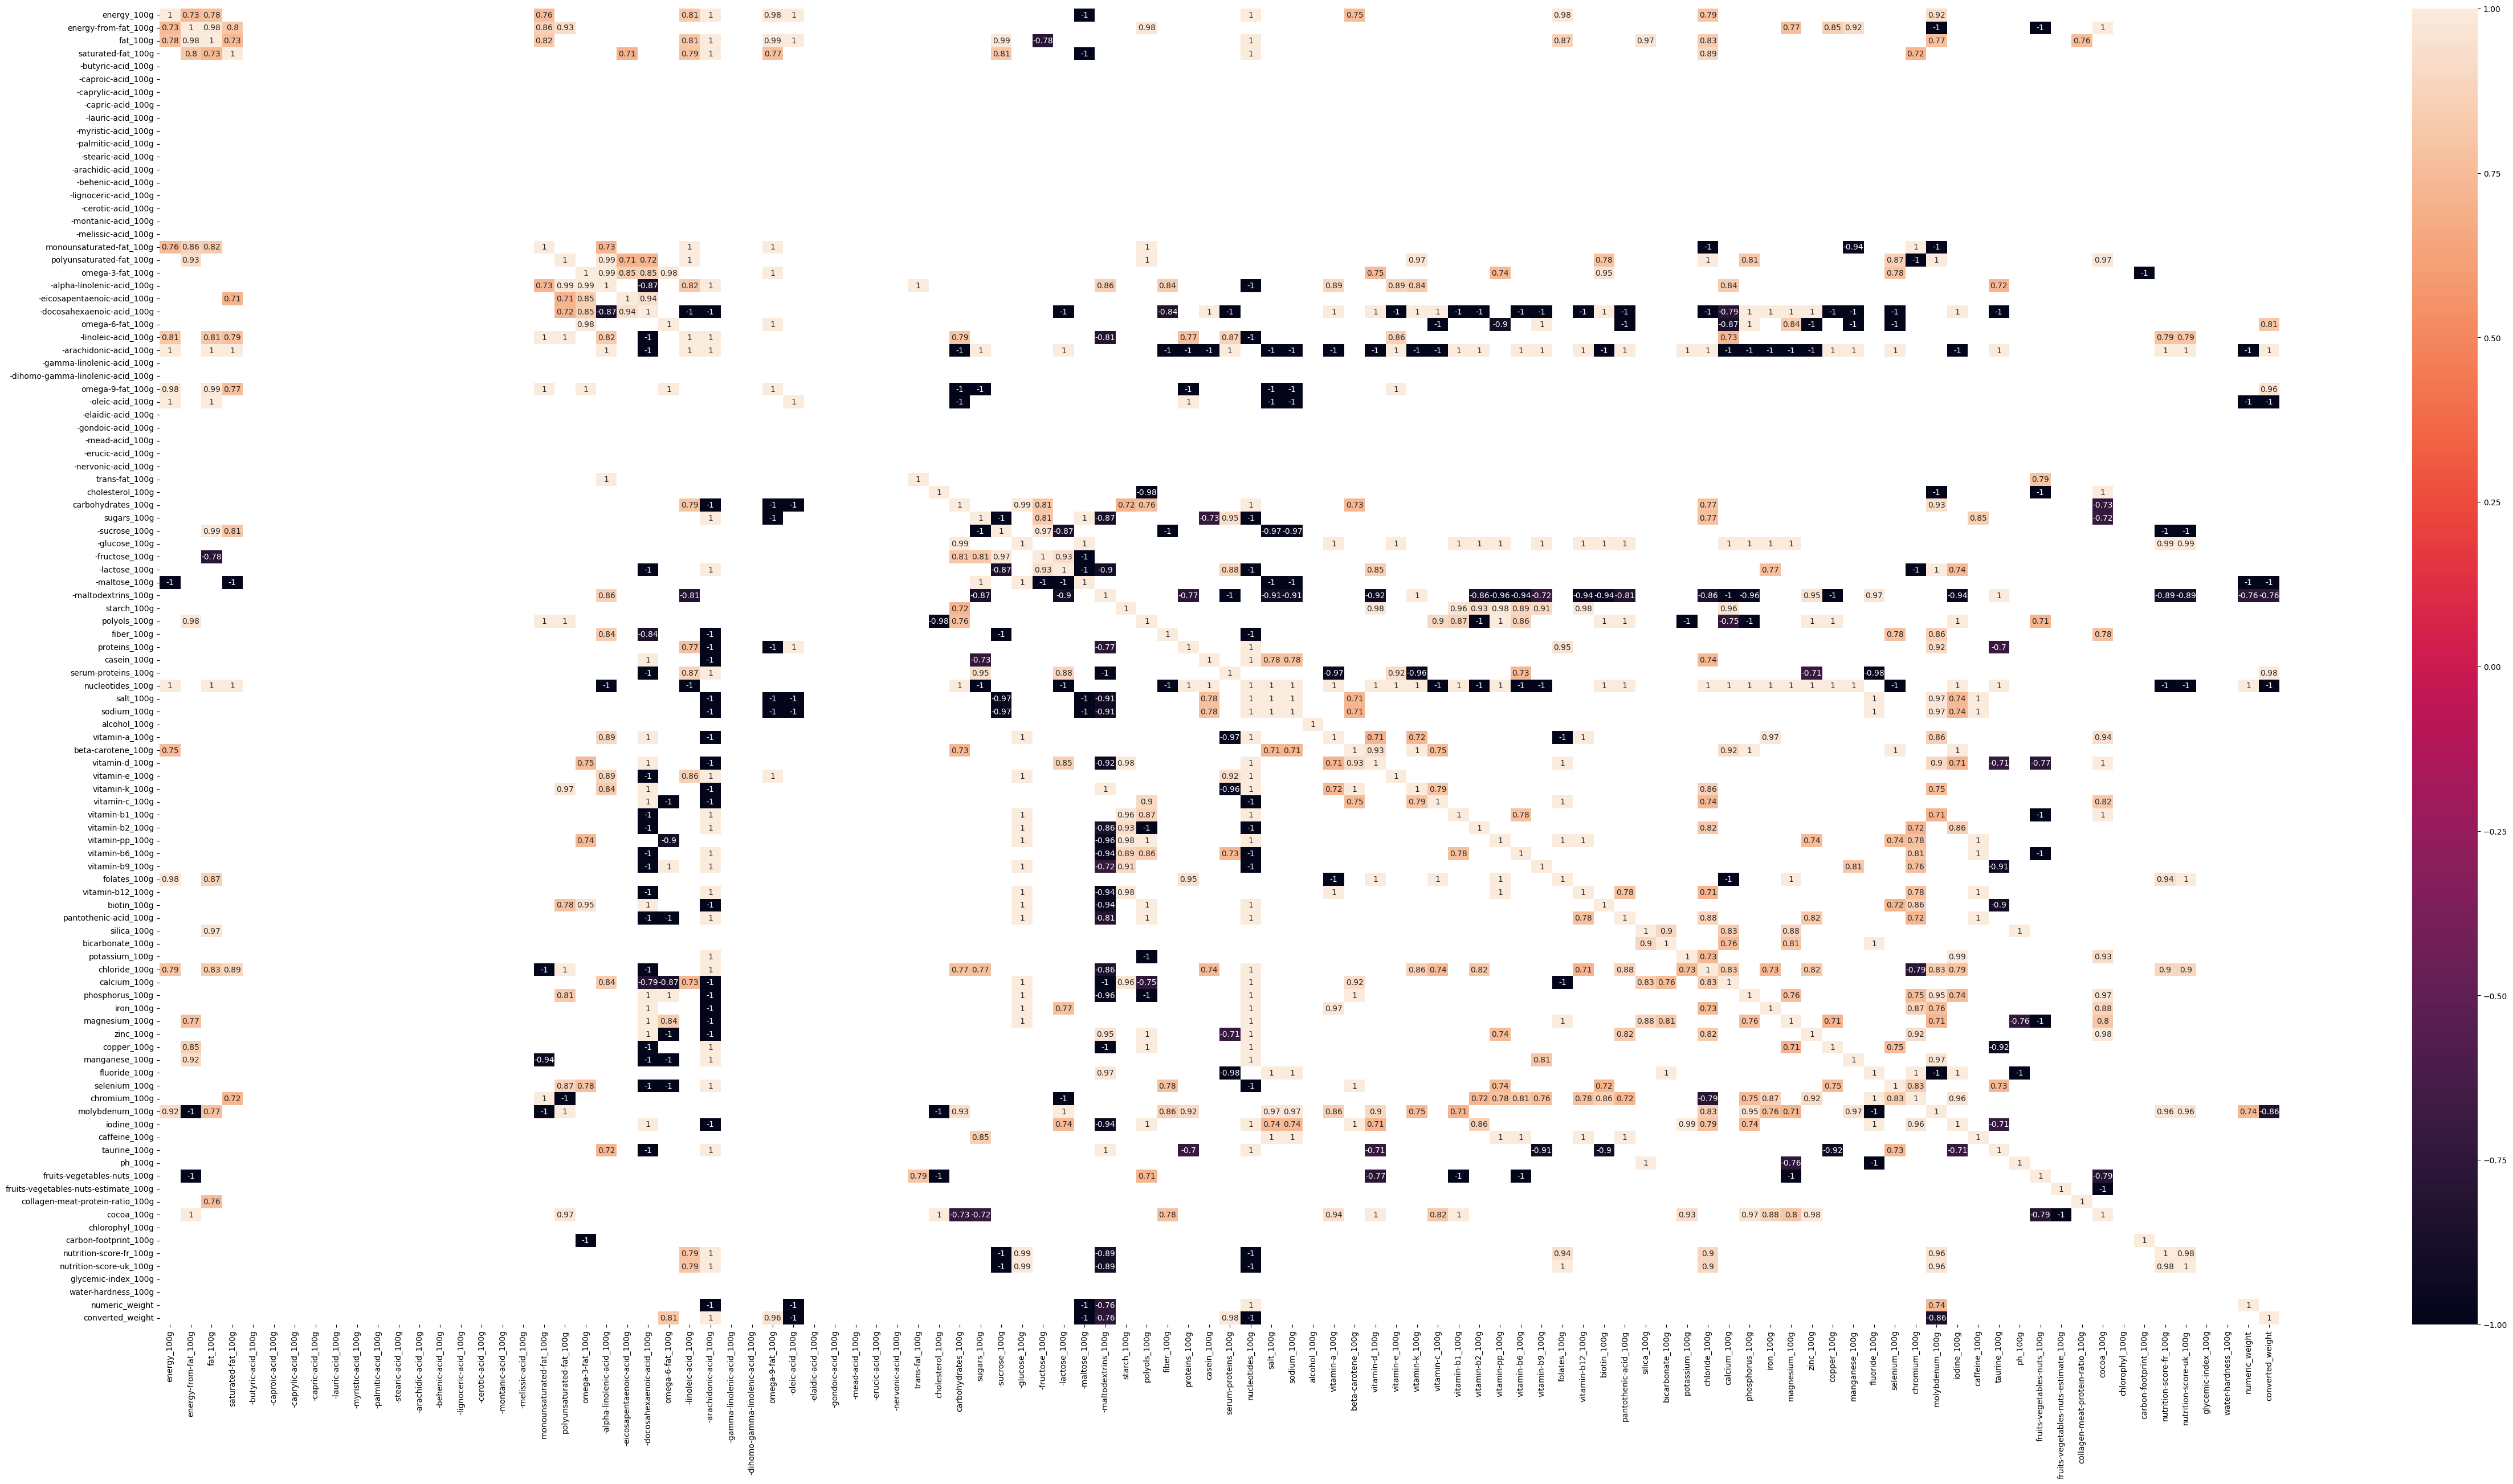

In [67]:
#doing a heatmap to see relation of weight with nutrition
'''
can see if any of the various nutrition levels are linked as well
'''
corr = foodproduct_corr.corr().copy()
filter_corr = corr[( corr > 0.7)|(corr < -0.7)]
plt.figure(figsize=(60,30))
heatmap = sns.heatmap(filter_corr, vmin=-1, vmax=1, annot=True)

